# **Talk TO PDFs**


0.   Installs, Imports and API Keys
1.   Loading PDFs and chunking with LangChain
2.   Embedding text and storing embeddings
3.   Creating retrieval function
4.   Creating chatbot with chat memory (OPTIONAL)








In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from transformers import GPT2TokenizerFast
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains.question_answering import load_qa_chain
from langchain.llms import OpenAI
from langchain.chains import ConversationalRetrievalChain

In [2]:
from key import openaiapi_key
os.environ["OPENAI_API_KEY"] = openaiapi_key

## 1. Loading PDFs and chunking with LangChain

In [3]:
# You MUST add your PDF to local files in this notebook (folder icon on left hand side of screen)

# Simple method - Split by pages
loader = PyPDFLoader("/Users/tarakram/Documents/TalkToPDF/story.pdf")
pages = loader.load_and_split()
print(pages[0])

# SKIP TO STEP 2 IF YOU'RE USING THIS METHOD
chunks = pages

page_content="The Terrible Old Man by H. P. Lovecraft Written on January 28, 1920, and originally published in Tryout magazine in 1921, The Terrible Old Man is of particular interest to fans of H.P. Lovecraft because it marks the introduction of Lovecraft's fictional geography, setting his work for the first time in the fictional New England town of Kingsport. H.P. Lovecraft's story is featured in our collection of Halloween Stories and is a fine example of Gothic Literature. \n Vincent van Gogh, An Old Man Putting Dry Rice on the Hearth, 1881" metadata={'source': '/Users/tarakram/Documents/TalkToPDF/story.pdf', 'page': 0}


In [4]:
# Advanced method - Split by chunk

# Step 1: Convert PDF to text
import textract
doc = textract.process("/Users/tarakram/Documents/TalkToPDF/story.pdf")

# Step 2: Save to .txt and reopen (helps prevent issues)
with open('story.txt', 'w') as f:
    f.write(doc.decode('utf-8'))

with open('story.txt', 'r') as f:
    text = f.read()

# Step 3: Create function to count tokens
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

def count_tokens(text: str) -> int:
    return len(tokenizer.encode(text))

# Step 4: Split text into chunks
text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size = 512,
    chunk_overlap  = 24,
    length_function = count_tokens,
)

chunks = text_splitter.create_documents([text])

Token indices sequence length is longer than the specified maximum sequence length for this model (1469 > 1024). Running this sequence through the model will result in indexing errors


In [5]:
# Result is many LangChain 'Documents' around 500 tokens or less (Recursive splitter sometimes allows more tokens to retain context)
type(chunks[0])

langchain.schema.Document

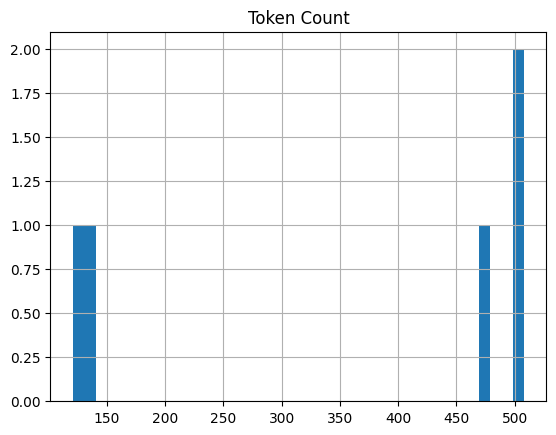

In [6]:
# Quick data visualization to ensure chunking was successful

# Create a list of token counts
token_counts = [count_tokens(chunk.page_content) for chunk in chunks]

# Create a DataFrame from the token counts
df = pd.DataFrame({'Token Count': token_counts})

# Create a histogram of the token count distribution
df.hist(bins=40, )

# Show the plot
plt.show()

## 2. Embed text and store embeddings

In [7]:
# Get embedding model
embeddings = OpenAIEmbeddings()

# Create vector database
db = FAISS.from_documents(chunks, embeddings)

## 3. Setup retrieval function

In [8]:
# Check similarity search is working
query = "What is the name of the author?"
docs = db.similarity_search(query)
docs[0]

Document(page_content="The Terrible Old Man \nby H. P. Lovecraft \n\nWritten on January 28, 1920, and originally published in Tryout magazine in 1921, The Terrible Old Man is \nof particular interest to fans of H.P. Lovecraft because it marks the introduction of Lovecraft's fictional \ngeography, setting his work for the first time in the fictional New England town of Kingsport. H.P. \nLovecraft's story is featured in our collection of Halloween Stories and is a fine example of Gothic \nLiterature. \n\nVincent van Gogh, An Old Man Putting Dry Rice on the Hearth, 1881", metadata={})

In [9]:
# Create QA chain to integrate similarity search with user queries (answer query from knowledge base)

chain = load_qa_chain(OpenAI(temperature=0), chain_type="stuff")

query = "What is the name of the author?"
docs = db.similarity_search(query)

chain.run(input_documents=docs, question=query)

' The author is H.P. Lovecraft.'

## 5. Create chatbot with chat memory 

In [10]:
from IPython.display import display
import ipywidgets as widgets

# Create conversation chain that uses our vectordb as retriver, this also allows for chat history management
qa = ConversationalRetrievalChain.from_llm(OpenAI(temperature=0.1), db.as_retriever())

In [ ]:
chat_history = []

def on_submit(_):
    query = input_box.value
    input_box.value = ""

    if query.lower() == 'exit':
        print("Thank you for using the State of the Union chatbot!")
        return

    result = qa({"question": query, "chat_history": chat_history})
    chat_history.append((query, result['answer']))

    display(widgets.HTML(f'<b>User:</b> {query}'))
    display(widgets.HTML(f'<b><font color="blue">Chatbot:</font></b> {result["answer"]}'))

print("Welcome to the Transformers chatbot! Type 'exit' to stop.")

input_box = widgets.Text(placeholder='Please enter your question:')
input_box.on_submit(on_submit)

display(input_box)

Welcome to the Transformers chatbot! Type 'exit' to stop.


/var/folders/dq/p63wvjv16y3br2t7sc1d8nl80000gn/T/ipykernel_17054/3589111581.py:20: DeprecationWarning: on_submit is deprecated. Instead, set the .continuous_update attribute to False and observe the value changing with: mywidget.observe(callback, 'value').
  input_box.on_submit(on_submit)


Text(value='', placeholder='Please enter your question:')

HTML(value='<b>User:</b> what is the name of the author ?')

HTML(value='<b><font color="blue">Chatbot:</font></b>  The author is H. P. Lovecraft.')

Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-text-davinci-003 in organization org-k3rFQVzLTjqcQvdhmNvgLgmq on requests per min. Limit: 3 / min. Please try again in 20s. Contact us through our help center at help.openai.com if you continue to have issues. Please add a payment method to your account to increase your rate limit. Visit https://platform.openai.com/account/billing to add a payment method..
Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-text-davinci-003 in organization org-k3rFQVzLTjqcQvdhmNvgLgmq on requests per min. Limit: 3 / min. Please try again in 20s. Contact us through our help center at help.openai.com if you continue to have issues. Please add a payment method to your account to increase your rate limit. Visit https://platform.openai.com/acco

HTML(value='<b>User:</b> give me summary ')

HTML(value='<b><font color="blue">Chatbot:</font></b>  H. P. Lovecraft\'s work The Terrible Old Man is a short…

HTML(value='<b>User:</b> when this is published ?')

HTML(value='<b><font color="blue">Chatbot:</font></b>  The Terrible Old Man by H. P. Lovecraft was originally …

Thank you for using the State of the Union chatbot!
